# 03 - Embedding-Based Zero-Shot Classification

**Approach 2: Semantic Similarity with Sentence Embeddings**

This notebook develops and evaluates the embedding-based zero-shot classifier for:
- **Department (Domain)** prediction
- **Seniority** prediction

## How It Works
1. Create embeddings for each label (using label names or examples from CSV)
2. Encode input job title as embedding
3. Compute cosine similarity between input and all label embeddings
4. Predict label with highest similarity

## Advantages
- No training required (zero-shot)
- Handles semantic similarity ("Developer" ≈ "Engineer")
- Works across languages (with multilingual model)

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Our modules
from src.models.embedding_classifier import (
    EmbeddingClassifier,
    EmbeddingConfig,
    RECOMMENDED_MODELS,
    create_domain_classifier,
    create_seniority_classifier
)
from src.evaluation.metrics import (
    evaluate_predictions,
    plot_confusion_matrix,
    get_classification_report,
    analyze_errors,
    compare_models
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
DATA_DIR = Path('../data')

print("Setup complete!")
print(f"\nRecommended models:")
for name, model in RECOMMENDED_MODELS.items():
    print(f"  {name}: {model}")

Setup complete!

Recommended models:
  fast: paraphrase-multilingual-MiniLM-L12-v2
  balanced: paraphrase-multilingual-mpnet-base-v2
  accurate: distiluse-base-multilingual-cased-v2
  english_only: all-MiniLM-L6-v2


## 1. Load Data

In [2]:
# Load annotated CVs
with open(DATA_DIR / 'linkedin-cvs-annotated.json', 'r', encoding='utf-8') as f:
    cvs_annotated = json.load(f)

# Load label dictionaries
department_df = pd.read_csv(DATA_DIR / 'department-v2.csv')
seniority_df = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

print(f"Annotated CVs: {len(cvs_annotated)}")
print(f"Department patterns: {len(department_df)} ({department_df['label'].nunique()} unique labels)")
print(f"Seniority patterns: {len(seniority_df)} ({seniority_df['label'].nunique()} unique labels)")

Annotated CVs: 609
Department patterns: 10145 (11 unique labels)
Seniority patterns: 9428 (5 unique labels)


In [3]:
# Flatten CVs to get active positions
def extract_active_positions(cvs):
    records = []
    for cv_id, cv in enumerate(cvs):
        for pos in cv:
            if pos.get('status') == 'ACTIVE':
                records.append({
                    'cv_id': cv_id,
                    'position': pos.get('position', ''),
                    'organization': pos.get('organization', ''),
                    'department': pos.get('department', 'Unknown'),
                    'seniority': pos.get('seniority', 'Unknown')
                })
    return pd.DataFrame(records)

df = extract_active_positions(cvs_annotated)
print(f"Active positions: {len(df)}")
df.head()

Active positions: 623


,cv_id,position,organization,department,seniority
0,0,Prokurist,Depot4Design GmbH,Other,Management
1,0,CFO,Depot4Design GmbH,Other,Management
2,0,Betriebswirtin,Depot4Design GmbH,Other,Professional
3,0,Prokuristin,Depot4Design GmbH,Other,Management
4,0,CFO,Depot4Design GmbH,Other,Management


In [4]:
# Train/test split by CV
from sklearn.model_selection import train_test_split

unique_cvs = df['cv_id'].unique()
train_cvs, test_cvs = train_test_split(unique_cvs, test_size=0.2, random_state=42)

train_df = df[df['cv_id'].isin(train_cvs)].copy()
test_df = df[df['cv_id'].isin(test_cvs)].copy()

print(f"Train: {len(train_df)} positions")
print(f"Test: {len(test_df)} positions")

Train: 496 positions
Test: 127 positions


## 2. Initialize Embedding Model

We use a **multilingual** model since the data contains German, French, and English job titles.

In [5]:
# This will download the model on first run (~500MB)
# Using the fast multilingual model
config = EmbeddingConfig(
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    batch_size=64,
    normalize=True
)

print(f"Using model: {config.model_name}")
print(f"Device: {config.device}")

Using model: paraphrase-multilingual-MiniLM-L12-v2
Device: cuda


## 3. Department Classification

In [6]:
# Get unique department labels
dept_labels = department_df['label'].unique().tolist()
print(f"Department labels ({len(dept_labels)}):")
print(dept_labels)

Department labels (11):
['Marketing', 'Project Management', 'Administrative', 'Business Development', 'Consulting', 'Human Resources', 'Information Technology', 'Other', 'Purchasing', 'Sales', 'Customer Support']


### 3.1 Strategy 1: Label Names Only (Pure Zero-Shot)

In [7]:
# Create classifier with just label names
dept_clf_simple = EmbeddingClassifier(dept_labels, config)
dept_clf_simple.fit()  # No examples, just uses label names

# Test on examples
test_titles = [
    "Marketing Manager",
    "Software Engineer",
    "Geschäftsführer",
    "Chef de projet",
    "Vertriebsleiter",
]

print("Pure zero-shot predictions (label names only):")
for title in test_titles:
    pred, conf, scores = dept_clf_simple.predict_single(title)
    print(f"  '{title}' -> {pred} (similarity: {conf:.3f})")

Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Computing embeddings for 11 labels...
Label embeddings computed: shape (11, 384)
Pure zero-shot predictions (label names only):
  'Marketing Manager' -> Marketing (similarity: 0.796)
  'Software Engineer' -> Information Technology (similarity: 0.536)
  'Geschäftsführer' -> Administrative (similarity: 0.707)
  'Chef de projet' -> Project Management (similarity: 0.733)
  'Vertriebsleiter' -> Marketing (similarity: 0.664)


In [8]:
# Evaluate on test set
dept_preds_simple = dept_clf_simple.predict(test_df['position'].tolist())

metrics_simple = evaluate_predictions(test_df['department'].tolist(), dept_preds_simple)
print("Label Names Only - Department:")
for k, v in metrics_simple.items():
    print(f"  {k}: {v:.3f}")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Label Names Only - Department:
  accuracy: 0.220
  f1_macro: 0.248
  f1_weighted: 0.199
  precision_macro: 0.323
  recall_macro: 0.385
  coverage: 1.000


### 3.2 Strategy 2: Averaged Example Embeddings (Recommended)

In [9]:
# Create classifier using example centroids
dept_clf_centroid = EmbeddingClassifier(dept_labels, config)
dept_clf_centroid.fit_from_examples(department_df, n_examples=50)

print("\nCentroid-based predictions (averaged examples):")
for title in test_titles:
    pred, conf, scores = dept_clf_centroid.predict_single(title)
    print(f"  '{title}' -> {pred} (similarity: {conf:.3f})")

Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 11 labels, shape (11, 384)

Centroid-based predictions (averaged examples):
  'Marketing Manager' -> Marketing (similarity: 0.769)
  'Software Engineer' -> Consulting (similarity: 0.682)
  'Geschäftsführer' -> Other (similarity: 0.832)
  'Chef de projet' -> Project Management (similarity: 0.869)
  'Vertriebsleiter' -> Sales (similarity: 0.852)


In [10]:
# Evaluate centroid approach
dept_preds_centroid = dept_clf_centroid.predict(test_df['position'].tolist())

metrics_centroid = evaluate_predictions(test_df['department'].tolist(), dept_preds_centroid)
print("Averaged Examples (Centroids) - Department:")
for k, v in metrics_centroid.items():
    print(f"  {k}: {v:.3f}")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Averaged Examples (Centroids) - Department:
  accuracy: 0.370
  f1_macro: 0.362
  f1_weighted: 0.390
  precision_macro: 0.366
  recall_macro: 0.446
  coverage: 1.000


In [11]:
# Compare strategies
print("\n=== Department Strategy Comparison ===")
comparison = pd.DataFrame([
    {'Strategy': 'Label names only', **metrics_simple},
    {'Strategy': 'Averaged examples', **metrics_centroid},
])
print(comparison[['Strategy', 'accuracy', 'f1_macro', 'f1_weighted']].to_string(index=False))


=== Department Strategy Comparison ===
         Strategy  accuracy  f1_macro  f1_weighted
 Label names only  0.220472   0.24827     0.199473
Averaged examples  0.370079   0.36192     0.389996


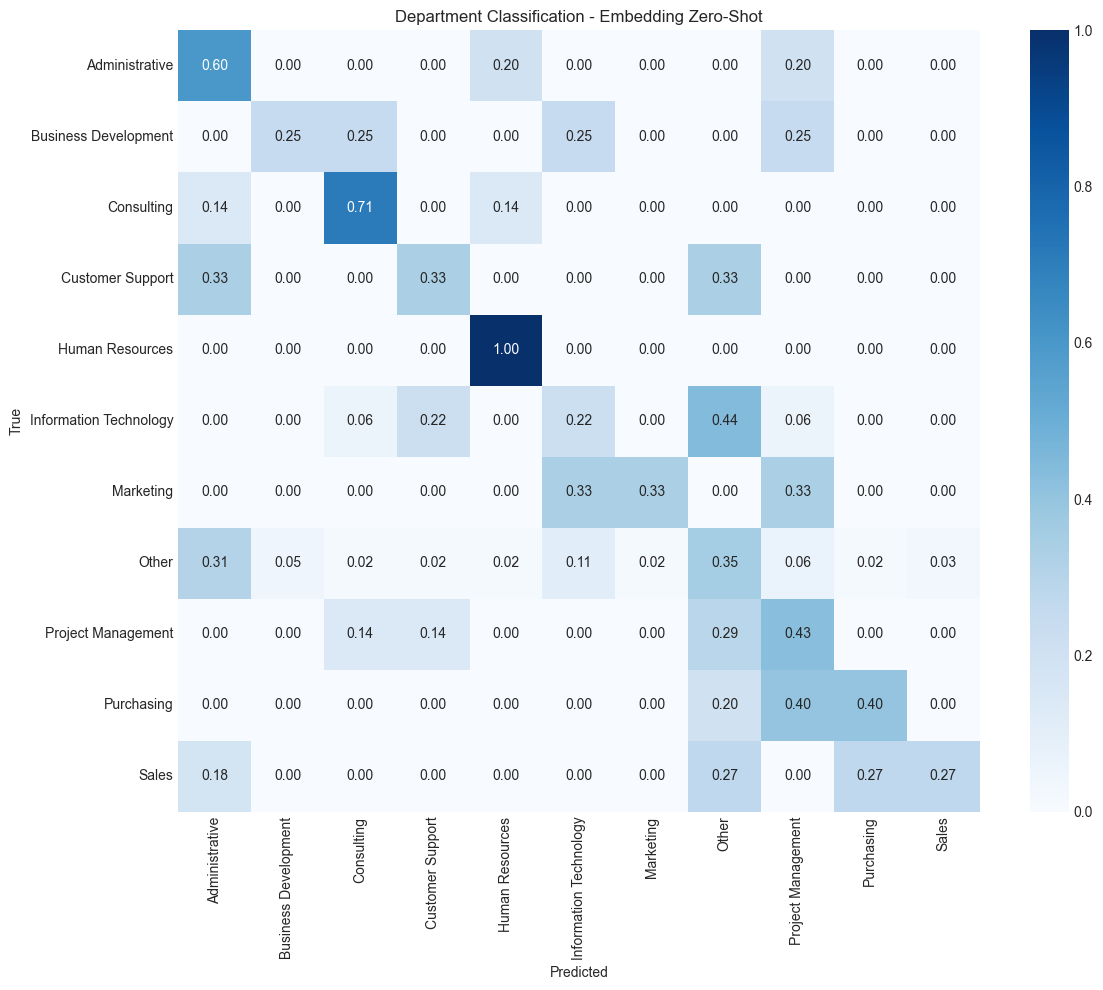

In [12]:
# Confusion matrix (using better strategy)
best_dept_preds = dept_preds_centroid if metrics_centroid['f1_macro'] > metrics_simple['f1_macro'] else dept_preds_simple

fig = plot_confusion_matrix(
    test_df['department'].tolist(),
    best_dept_preds,
    title="Department Classification - Embedding Zero-Shot",
    figsize=(12, 10),
    normalize=True
)
plt.savefig('../reports/figures/embedding_dept_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Seniority Classification

In [13]:
# Seniority labels
seniority_labels = seniority_df['label'].unique().tolist()
print(f"Seniority labels ({len(seniority_labels)}):")
print(seniority_labels)

Seniority labels (5):
['Junior', 'Senior', 'Lead', 'Management', 'Director']


In [14]:
# Create seniority classifier with centroids
seniority_clf = EmbeddingClassifier(seniority_labels, config)
seniority_clf.fit_from_examples(seniority_df, n_examples=50)

# Test examples
test_sen_titles = [
    "CEO",
    "Senior Software Engineer",
    "Junior Analyst",
    "Team Lead",
    "Praktikant",
    "Directeur",
]

print("Seniority predictions:")
for title in test_sen_titles:
    pred, conf, _ = seniority_clf.predict_single(title)
    print(f"  '{title}' -> {pred} (similarity: {conf:.3f})")

Loading model 'paraphrase-multilingual-MiniLM-L12-v2' on cuda...
Model loaded successfully!
Fitted from examples: 5 labels, shape (5, 384)
Seniority predictions:
  'CEO' -> Management (similarity: 0.850)
  'Senior Software Engineer' -> Junior (similarity: 0.591)
  'Junior Analyst' -> Junior (similarity: 0.644)
  'Team Lead' -> Lead (similarity: 0.531)
  'Praktikant' -> Junior (similarity: 0.664)
  'Directeur' -> Management (similarity: 0.862)


In [15]:
# Evaluate seniority
seniority_preds = seniority_clf.predict(test_df['position'].tolist())

metrics_seniority = evaluate_predictions(test_df['seniority'].tolist(), seniority_preds)
print("Embedding Zero-Shot - Seniority:")
for k, v in metrics_seniority.items():
    print(f"  {k}: {v:.3f}")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding Zero-Shot - Seniority:
  accuracy: 0.299
  f1_macro: 0.246
  f1_weighted: 0.251
  precision_macro: 0.217
  recall_macro: 0.349
  coverage: 1.000


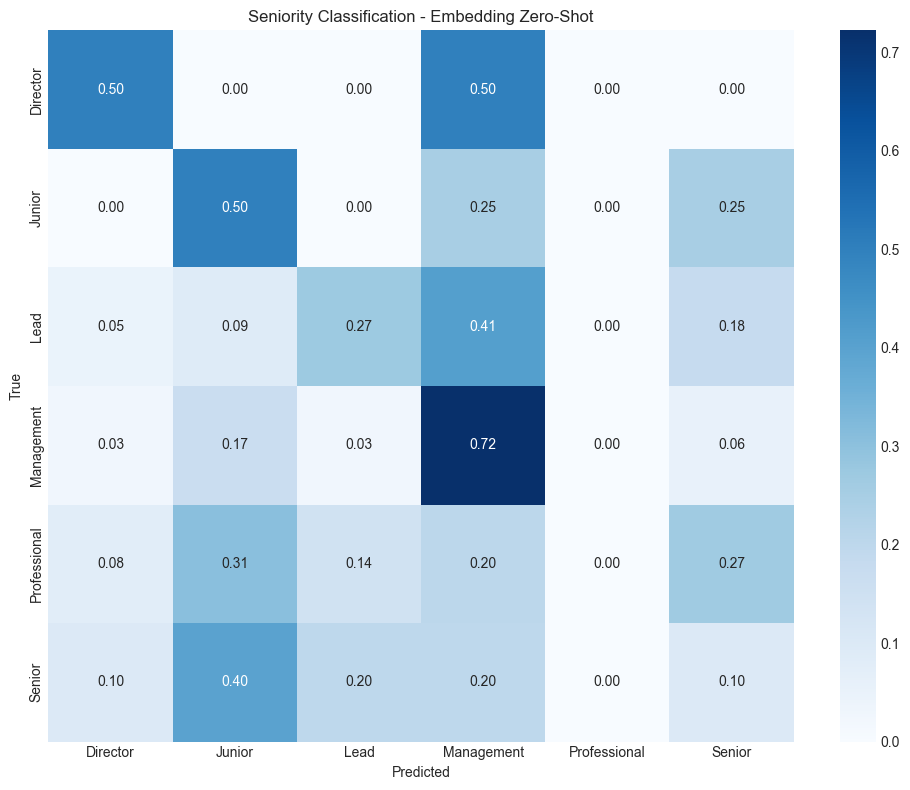

In [16]:
# Seniority confusion matrix
fig = plot_confusion_matrix(
    test_df['seniority'].tolist(),
    seniority_preds,
    title="Seniority Classification - Embedding Zero-Shot",
    figsize=(10, 8),
    normalize=True
)
plt.savefig('../reports/figures/embedding_seniority_confusion.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Analyze Similarity Scores

In [17]:
# Get top-3 predictions for some examples
sample_titles = test_df['position'].head(10).tolist()
top_k_preds = dept_clf_centroid.predict_top_k(sample_titles, k=3)

print("Top-3 Department Predictions:")
for title, top_k in zip(sample_titles, top_k_preds):
    print(f"\n'{title[:50]}...'" if len(title) > 50 else f"\n'{title}'")
    for label, score in top_k:
        print(f"    {label}: {score:.3f}")

Top-3 Department Predictions:

'Prokurist'
    Administrative: 0.644
    Sales: 0.554
    Information Technology: 0.547

'CFO'
    Other: 0.653
    Administrative: 0.629
    Consulting: 0.535

'Betriebswirtin'
    Information Technology: 0.692
    Customer Support: 0.657
    Sales: 0.582

'Prokuristin'
    Administrative: 0.720
    Consulting: 0.622
    Sales: 0.602

'CFO'
    Other: 0.653
    Administrative: 0.629
    Consulting: 0.535

'Set Lighting'
    Information Technology: 0.205
    Project Management: 0.190
    Administrative: 0.189

'Set Lighting'
    Information Technology: 0.205
    Project Management: 0.190
    Administrative: 0.189

'Set Lighting'
    Information Technology: 0.205
    Project Management: 0.190
    Administrative: 0.189

'Set Lighting'
    Information Technology: 0.205
    Project Management: 0.190
    Administrative: 0.189

'Set Lighting'
    Information Technology: 0.205
    Project Management: 0.190
    Administrative: 0.189


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

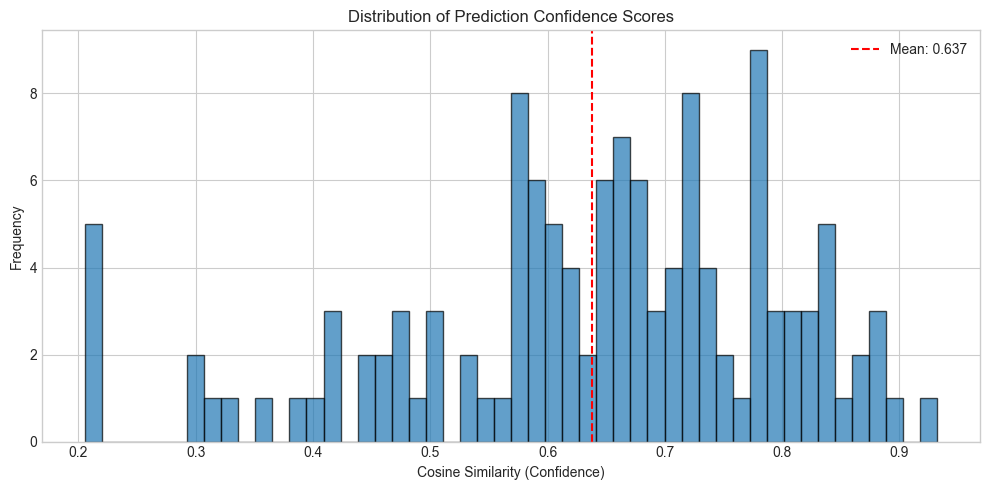

Confidence stats: min=0.205, max=0.932, mean=0.637


In [18]:
# Visualize similarity score distribution
dept_preds_with_conf = dept_clf_centroid.predict_with_confidence(test_df['position'].tolist())
confidences = [conf for _, conf in dept_preds_with_conf]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(confidences, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Cosine Similarity (Confidence)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Prediction Confidence Scores')
ax.axvline(np.mean(confidences), color='red', linestyle='--', label=f'Mean: {np.mean(confidences):.3f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Confidence stats: min={min(confidences):.3f}, max={max(confidences):.3f}, mean={np.mean(confidences):.3f}")

## 6. Error Analysis

In [19]:
# Department errors
print("=== Department Errors ===")
dept_errors = analyze_errors(
    test_df['position'].tolist(),
    test_df['department'].tolist(),
    best_dept_preds,
    n_samples=15
)
dept_errors

=== Department Errors ===


,text,true_label,predicted_label
30,Self-Employed at Kodestuen ApS,Other,Administrative
0,Prokurist,Other,Administrative
22,Interims Technical Manager,Information Technology,Other
31,Head of Package & Installation Design IGC,Project Management,Customer Support
18,Director of Product Management,Project Management,Other
28,Vorsitzender des Vorstandes,Other,Administrative
10,Senior IT-Sicherheitsbeauftragter,Information Technology,Other
70,Baubeamter,Other,Administrative
4,Set Lighting,Other,Information Technology
12,Product Manager,Project Management,Other


In [20]:
# Seniority errors
print("=== Seniority Errors ===")
sen_errors = analyze_errors(
    test_df['position'].tolist(),
    test_df['seniority'].tolist(),
    seniority_preds,
    n_samples=15
)
sen_errors

=== Seniority Errors ===


,text,true_label,predicted_label
44,Data Analyst,Professional,Junior
53,Vertriebsingenieur,Professional,Senior
30,Lehrbeauftragter,Lead,Management
12,Senior IT-Sicherheitsbeauftragter,Senior,Junior
49,Marktondersteuning,Junior,Senior
0,Prokurist,Management,Junior
64,Schornsteinfeger Meisterbetrieb,Lead,Management
18,Head of aws Preseed and Seedfinancing - Innova...,Lead,Senior
10,Bereichsleiter Maschinen,Lead,Management
22,Head of Glass Technology,Lead,Senior


## 7. Compare with Rule-Based Baseline

In [21]:
# Import rule-based for comparison
from src.models.rule_based import create_department_classifier as create_rule_dept, create_seniority_classifier as create_rule_sen

rule_dept_clf = create_rule_dept(department_df)
rule_sen_clf = create_rule_sen(seniority_df)

rule_dept_preds = rule_dept_clf.predict(test_df['position'].tolist())
rule_sen_preds = rule_sen_clf.predict(test_df['position'].tolist())

metrics_rule_dept = evaluate_predictions(test_df['department'].tolist(), rule_dept_preds)
metrics_rule_sen = evaluate_predictions(test_df['seniority'].tolist(), rule_sen_preds)

In [22]:
# Comparison table
comparison_dept = pd.DataFrame([
    {'Model': 'Rule-Based', 'Task': 'Department', **metrics_rule_dept},
    {'Model': 'Embedding', 'Task': 'Department', **metrics_centroid},
])

comparison_sen = pd.DataFrame([
    {'Model': 'Rule-Based', 'Task': 'Seniority', **metrics_rule_sen},
    {'Model': 'Embedding', 'Task': 'Seniority', **metrics_seniority},
])

comparison = pd.concat([comparison_dept, comparison_sen])

print("=== Model Comparison ===")
print(comparison[['Model', 'Task', 'accuracy', 'f1_macro', 'f1_weighted']].to_string(index=False))

=== Model Comparison ===
     Model       Task  accuracy  f1_macro  f1_weighted
Rule-Based Department  0.708661  0.572888     0.690509
 Embedding Department  0.370079  0.361920     0.389996
Rule-Based  Seniority  0.574803  0.497614     0.596729
 Embedding  Seniority  0.299213  0.245703     0.250745


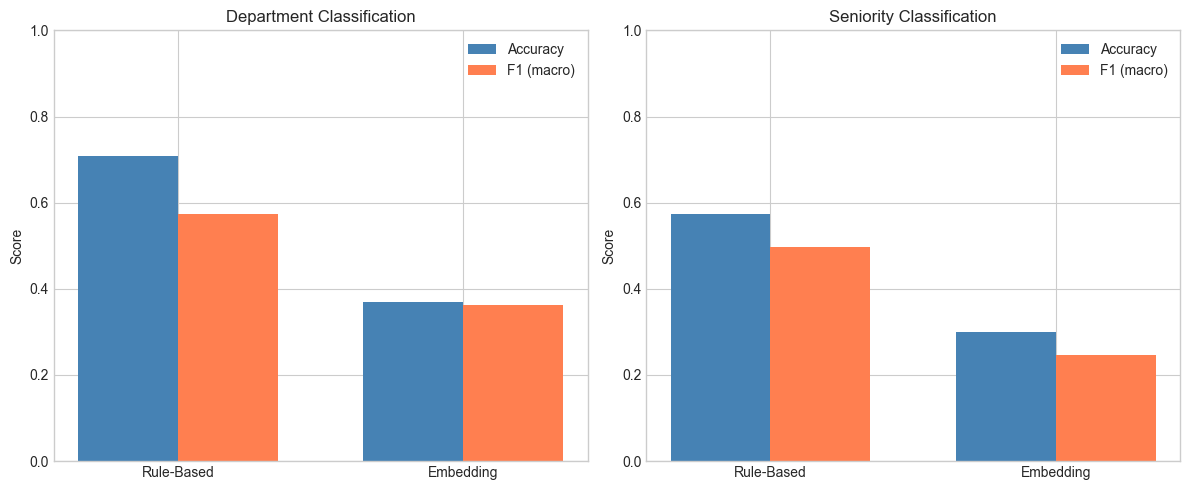

In [23]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Department comparison
dept_data = comparison[comparison['Task'] == 'Department']
x = np.arange(2)
width = 0.35
axes[0].bar(x - width/2, dept_data['accuracy'], width, label='Accuracy', color='steelblue')
axes[0].bar(x + width/2, dept_data['f1_macro'], width, label='F1 (macro)', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(dept_data['Model'])
axes[0].set_ylabel('Score')
axes[0].set_title('Department Classification')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Seniority comparison
sen_data = comparison[comparison['Task'] == 'Seniority']
axes[1].bar(x - width/2, sen_data['accuracy'], width, label='Accuracy', color='steelblue')
axes[1].bar(x + width/2, sen_data['f1_macro'], width, label='F1 (macro)', color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(sen_data['Model'])
axes[1].set_ylabel('Score')
axes[1].set_title('Seniority Classification')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary

In [24]:
print("=== Embedding-Based Zero-Shot Results ===")
print(f"\nDepartment: Accuracy={metrics_centroid['accuracy']:.3f}, F1={metrics_centroid['f1_macro']:.3f}")
print(f"Seniority: Accuracy={metrics_seniority['accuracy']:.3f}, F1={metrics_seniority['f1_macro']:.3f}")
print(f"\nModel: {config.model_name}")
print(f"Strategy: Averaged example embeddings (centroids)")

=== Embedding-Based Zero-Shot Results ===

Department: Accuracy=0.370, F1=0.362
Seniority: Accuracy=0.299, F1=0.246

Model: paraphrase-multilingual-MiniLM-L12-v2
Strategy: Averaged example embeddings (centroids)


## 9. Ideas for Improvement

1. **Try different models** - Test `paraphrase-multilingual-mpnet-base-v2` for better quality
2. **Custom label descriptions** - Write better descriptions for ambiguous labels
3. **Confidence thresholding** - Reject low-confidence predictions
4. **Ensemble** - Combine with rule-based for better coverage
5. **Fine-tuning** - Fine-tune the embedding model on your data (Approach 3)

Try your experiments below!

In [25]:
# Your experiments here
# Example: Try a different model

# config_mpnet = EmbeddingConfig(
#     model_name='paraphrase-multilingual-mpnet-base-v2',
#     batch_size=32
# )
# ...